In [3]:
# imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

### Calibrate function 
The following is the calibrate function. It takes a list of path to calibration images
and then calibrate the camera. It is important the images show the checkerboard from 
different angles, and appearing in all the places within the frame. Also *super important*:
if you have hi-res pictures, findChessboardCorner may not work. And if you try to
scale down, the camera matrix will be wrong 

In [12]:
def calibrate(images, nx=9, ny=6, _debug=False):
    """Given a set of image paths for calibration,
       calibrates the camera and returns the camera
       matrix and distortion parameters"""

    # prepare the arrays to return
    obj_points = []  # 3D points in the real world space
    img_points = []  # 2D points in the image

    # prepare object points, like (0, 0, 0), (1, 0, 0)...(5,8,0)...
    # the z coordinate is assumed to be always 0 (chessboard laying on a flat
    # plane where only x and y varies
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # size of the images
    img_size = ()

    # for every image file
    for fname in images:

        # read each image
        img = mpimg.imread(fname)

        # store the size
        img_size = (img.shape[1], img.shape[0])

        # convert image to gray
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # find the chessboard corner
        found, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # if found corners...
        if found:

            # ... append those corners to the output array
            img_points.append(corners)

            # and append the corresponding world coordinates too
            obj_points.append(objp)

            # DEBUG draw and display the corners on the image
            if _debug:
               cv2.drawChessboardCorners(img, (nx, ny), corners, found)
               cv2.imshow('annotated', img)
               cv2.waitKey(500)

    # finally calibrate the camera
    retval, cameraMatrix, distCoeffs, _, _ = \
        cv2.calibrateCamera(obj_points, img_points, img_size, None, None)

    # return results
    return retval, cameraMatrix, distCoeffs

Hereafter I save the camera matrix and the distortion coefficients to pickle files.

In [15]:
# testing the calibrate, undistort and projection functions

# load camera matrix and distortion coeffs from pickle file or
# calibrate camera
try:
    cameraMatrix = pickle.load(open("cmx.p", "rb"))
    distCoeffs = pickle.load(open("dist.p", "rb"))

except (OSError, IOError) as e:
    # find image paths for calibration
    paths = glob.glob('camera_cal/calibration*.jpg')

assert(paths)

# calibrate the camera
retval, cameraMatrix, distCoeffs = calibrate(paths)

if retval:
    # if successfully calibrated, store the camera matrix
    # and distortion coeffs
    pickle.dump(cameraMatrix, open("cmx.p", "wb"))
    pickle.dump(distCoeffs, open("dist.p", "wb"))

print('Camera matrix = \n{}'.format(cameraMatrix))
print('Distortion coeffs = \n{}'.format(distCoeffs))

Camera matrix = 
[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion coeffs = 
[[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


Hereafter I test the calibration matrix and distortion coeffs by performing undistortion
on a test image

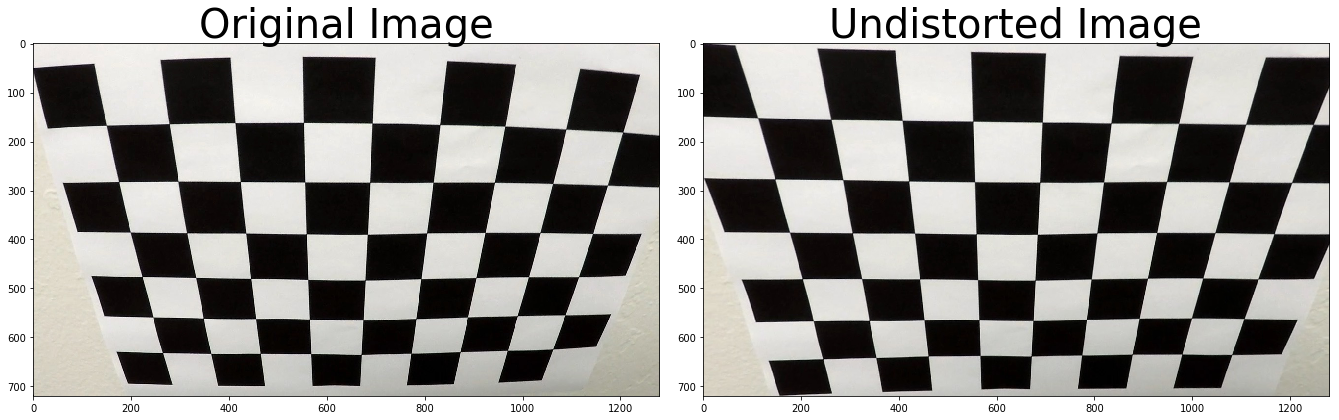

In [16]:
# load an image
small = mpimg.imread('camera_cal/calibration2.jpg')

# perform undistort
dst = cv2.undistort(small, cameraMatrix, distCoeffs, None, cameraMatrix)

# show original and undistort
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
ax1.imshow(small)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Perspective transform test

In [18]:
def corners_unwarp(img, nx, ny, mtx, dist):
    
    # 1) Undistort using mtx and dist
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)

    # 2) Convert to grayscale
    gray = cv2.cvtColor(dst_img, cv2.COLOR_BGR2GRAY)

    # 3) Find the chessboard corners
    found, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # 4) If corners found:
    if found:
        # a) draw corners
        cv2.drawChessboardCorners(gray, (nx, ny), corners, found)

        # 1st corner 0
        # 2nd corner nx - 1
        # 3rd corner (ny - 1) nx
        # 4th corner nx*ny - 1
        one = corners[0]
        two = corners[nx - 1]
        three = corners[(ny - 1) * nx]
        four = corners[-1]
        
        # create source and destination rectangle
        src = np.float32([one[0], two[0], four[0], three[0]])
        dst = np.float32([[10, 10], [1270, 10], [1270, 950], [10, 950]])

        # calculate the matrix to transform from src to dst
        M = cv2.getPerspectiveTransform(src, dst)
        
        img_size = (gray.shape[1], gray.shape[0])
         
        # change perspective
        warped = cv2.warpPerspective(dst_img, M, img_size,
                                     flags=cv2.INTER_LINEAR)

        
    return warped, M

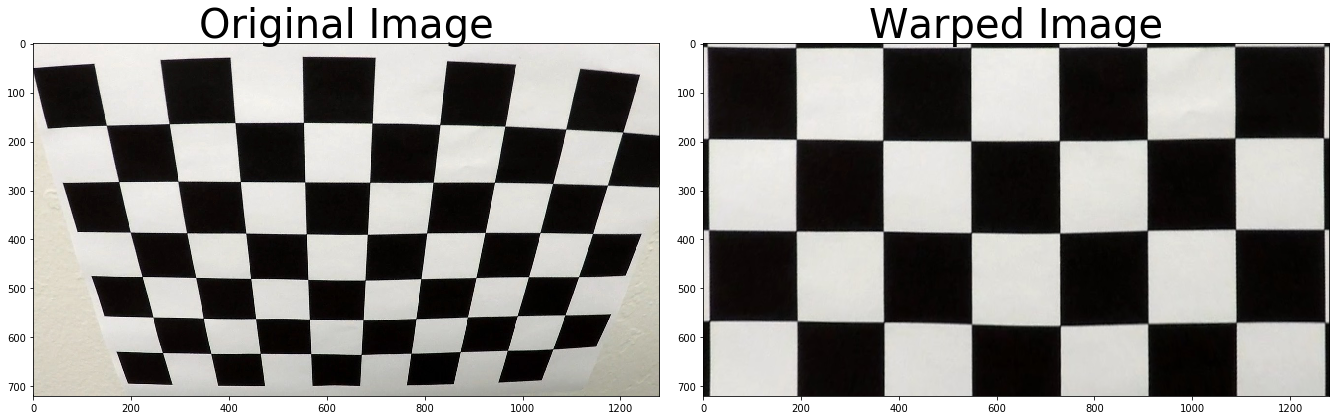

In [21]:
nx = 8  # the number of inside corners in x
ny = 6  # the number of inside corners in y

warped, perspective_M = corners_unwarp(small, nx, ny, cameraMatrix, distCoeffs)

# show original and warped

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
ax1.imshow(small)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()